### Import packages

In [26]:
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob 
import os
import json
from matplotlib.colors import LogNorm

In [27]:
#root_folder_path = "N:\\durable\\sound-and-ecg\\2024-10-Maja-restructured\\Data"
root_folder_path = "C:\\Users\\MajaE\\src\\repos\\master_ML\\Data"

### Extract data

In [28]:
def extract_test_parameters(test_file):
    true,predictions,predictions_proba,test_recording_ids,segment_parameters =[],[],[],[],[]
    with open(test_file, 'rb') as handle:
        true,predictions,predictions_proba,test_recording_ids, segment_parameters = pickle.load(handle) 
    return true,predictions,predictions_proba,test_recording_ids,segment_parameters

### Analyze metrics

In [29]:
def calculate_metrics(true,predictions):
    accuracy = accuracy_score(true, predictions) # ((TN + TP) / (TN + FN + TP + FP))
    precision = precision_score(true, predictions) # Positive predictive rate -> TP/(TP+FP)
    recall = recall_score(true, predictions) # Sensitivity -> TP/(TP+FN)
    confusion = confusion_matrix(true,predictions) # Confusion matrix
    tn, fp, fn, tp = confusion.ravel()
    specificity = tn / (tn+fp)
    return accuracy,recall,specificity,confusion, precision

In [30]:
def visualize_metrics(accuracy,recall,specificity,confusion, precision):
    print("Accuracy: ", accuracy)
    print("Sensitivity: ", recall)
    print("Precision: ", precision)
    print("Specificity: ", specificity)

    plt.figure()
    sns.heatmap(confusion,annot=True,fmt='d',cmap='Blues',norm=LogNorm())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(ticks=np.arange(len(classes))+0.5,labels=classes)
    plt.yticks(ticks=np.arange(len(classes))+0.5,labels=classes)
    plt.show()

### Plot ROC curve

In [31]:
def find_avg_performance(folder_path):
    test_files = glob.glob(os.path.join(folder_path,'*.pickle'))
    true, predictions, predictions_proba, ids, segment_parameters = [], [], [], [], []
    for test_file in test_files:
        true_subject, predictions_subject,predictions_proba_subject,test_recording_ids,segment_parameters_subject = extract_test_parameters(test_file)
        true.extend(true_subject)
        predictions.extend(predictions_subject)
        predictions_proba.extend(predictions_proba_subject)
        ids.extend(test_recording_ids)
        segment_parameters.extend([segment_parameters_subject])
    # for subject_idx in range(len(true)):
    #     accuracy,specificity,recall,confusion = calculate_metrics(true[subject_idx],predictions[subject_idx])
    true_concatenated = np.concatenate(true,axis=0)
    predictions_concatenated = np.concatenate(predictions,axis=0)
    accuracy,recall,specificity,confusion,precision = calculate_metrics(true_concatenated,predictions_concatenated)
    visualize_metrics(accuracy,recall,specificity,confusion,precision)
    return recall, specificity

In [32]:
def ROC_curve(sensitivity, specificity, labels):
    fpr = [1 - sp for sp in specificity]

    plt.figure()
    plt.plot(fpr, sensitivity, marker='o')
    plt.xlabel('False positive rate (FPR)')
    plt.ylabel('True positive rate (TPR)')
    plt.title('ROC curve with labelled parameter value')
    plt.grid(True)
    for i, label in enumerate(labels):
        plt.annotate(label, (fpr[i],sensitivity[i]))

plt.show()

In [33]:
def extract_test_ROC(root_folder_path):
    sensitivity = []
    specificity = []
    data_folder_path = os.path.join(root_folder_path,"data")
    for iteration in os.listdir(data_folder_path):
        iteration_path = os.path.join(data_folder_path,iteration)
        i_sensitivity, i_specificity = find_avg_performance(iteration_path)
        sensitivity.append(i_sensitivity)
        specificity.append(i_specificity)
    parameters_path = f"{root_folder_path}\\parameters.json"
    test_values = ""
    with open(parameters_path, 'r') as file:
        meta_data = json.load(file)
        test_values = meta_data["test_values"]
    ROC_curve(sensitivity, specificity,test_values)


Accuracy:  0.9016178309992003
Sensitivity:  0.5112798503356444
Precision:  0.9286428143114132
Specificity:  0.991003477647296


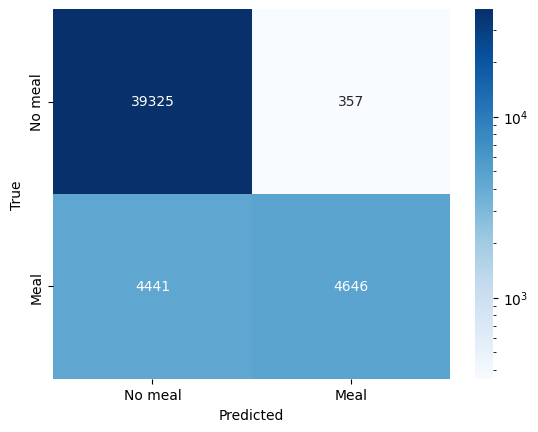

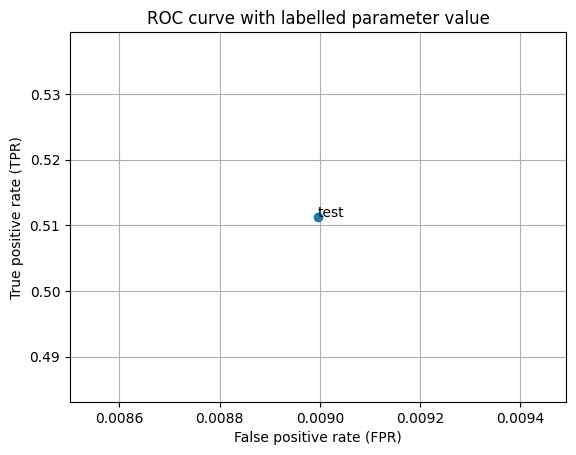

In [52]:
classes = ['No meal','Meal']
test_name = "LDA_test"
extract_test_ROC(test_name)


### Plot evolution of predictions

In [35]:
def calculate_seconds_between_the_subsequences(segment_parameters):
    [segment_length,overlap_length,n_segments] = segment_parameters
    step_length = segment_length - overlap_length
    subsequence_length = n_segments*step_length
    return step_length, subsequence_length

In [36]:
def find_meta_data(id):
    wav_files = []
    metadata_files = []
    recording_ids = []

    # Loop through each academic year in data folder
    root_folder_path_os = os.path.abspath(root_folder_path)
    for year_folder in os.listdir(root_folder_path_os):
        year_folder_path = os.path.join(root_folder_path_os,year_folder)
        # Ensure directory (folder)
        if os.path.isdir(year_folder_path): 
            # Loop through each subject in year
            for subject_folder in os.listdir(year_folder_path):
                subject_folder_path = os.path.join(year_folder_path,subject_folder)
                # Ensure directory (folder)
                if os.path.isdir(subject_folder_path): 
                    # Loop through each recording for subject
                    for recording_folder in os.listdir(subject_folder_path):
                        recording_folder_path = os.path.join(subject_folder_path,recording_folder)
                        if recording_folder == id:
                            if os.path.isdir(recording_folder_path):
                                metadata_file_path = os.path.join(recording_folder_path, f"{recording_folder}.json")
                                return metadata_file_path
    return None

In [37]:
def find_disturbances(id):
    print(id)
    id_file = find_meta_data(id)

    # Extract labels from metadata files
    meta_data = ""
    audio_offset = 0
    with open(id_file, 'r') as file:
        meta_data = json.load(file)
    if "audio_offset" in meta_data:
        audio_offset = meta_data["audio_offset"]
    disturbance_tuples = []
    disturbance_tuples.append((meta_data["mealStart"]-audio_offset,meta_data["mealEnd"]-audio_offset))

    if "disturbances" in meta_data:
        for disturbance in meta_data["disturbances"]:
            disturbance_tuples.append((disturbance["start"]-audio_offset,disturbance["end"]-audio_offset))
    return disturbance_tuples
    

In [38]:
def plot_evolution(true,predictions,disturbances,step_length,subsequence_length):
    time = np.linspace(subsequence_length,len(true)*step_length,len(true))
    plt.figure()
    
    for idx, (start, end) in enumerate(disturbances):
        if idx == 0:
            plt.axvspan(start, end, color="b", alpha=0.3)
        else: 
            plt.axvspan(start,end, color="r", alpha=0.3)
    #plt.step(time,true,color='b')
    plt.step(time,predictions,where='post',color='k',linestyle='-',label='Predicted')
    plt.title('Predictions of meal (1) or nonmeal (0) with disturbances')
    plt.xlabel('Time [s]')
    plt.ylabel('Meal or non meal')
    plt.legend()

    detection_time = 999
    (start,end) = disturbances[0]
    for idx, time_instance in enumerate(time):
        if time_instance>end:
            break
        elif time_instance>start:
            if predictions[idx] == 1:
                detection_time = time_instance - start
                break
        
    print('Detection time:',detection_time)


In [39]:
# Segments data into different segments for testing
def segment_labels(data, segment_size):
    segmented = []

    for i in range(len(data)):
        number_subsequences = len(data[i])//segment_size
        subject_segmented = []
        for j in range(0,number_subsequences):
            # Majority voting for the separate segments
            subsequence = round(np.mean(data[i][(j*segment_size):((j+1)*segment_size)]))
            subject_segmented.append(subsequence)
        segmented.append(subject_segmented)
    return segmented


In [40]:
def find_evolution_parameters(folder_path):
    test_files = glob.glob(os.path.join(folder_path,'*.pickle'))
    true, predictions, predictions_proba, ids, segment_parameters = [], [], [], [], [] 
    for test_file in test_files:
        true_subject,predictions_subject,predictions_proba_subject,test_recording_ids,segment_parameters_subject = extract_test_parameters(test_file)
        true.extend(true_subject)
        predictions.extend(predictions_subject)
        predictions_proba.extend(predictions_proba_subject)
        ids.extend(test_recording_ids)
        segment_parameters.extend([segment_parameters_subject])
    print(segment_parameters[0])
    step_length, subsequence_length = calculate_seconds_between_the_subsequences(segment_parameters[0])
    for subject_idx in range(len(true)):
        disturbances = find_disturbances(ids[subject_idx])
        plot_evolution(true[subject_idx],predictions[subject_idx],disturbances,step_length,subsequence_length)

[1, 0.5, 70]
37Bf8z
Detection time: 0.0740793201133556
3A9kCr
Detection time: 999
42sYtA
Detection time: 999
s6CzfK
Detection time: 16.288558214357522
bYUN6g
Detection time: 23.513640753259324
GUSjTH
Detection time: 34.06375390102539
Hvoq3y
Detection time: 0.007835874056127068
3X4wdj
Detection time: 999
35jaLn
Detection time: 2.5739795918367463
36FgVV
Detection time: 75.56543244771058
3V6TzJ
Detection time: 46.30829288879511
GqDZNs
Detection time: 0.23884514435701476
WEe7AK
Detection time: 13.62811183454619
dJbzPw
Detection time: 1.319786096256621
8pTLso
Detection time: 0.383376937009416
42Driv
Detection time: 6.049589118730523
GpFaF3
Detection time: 999
4HTc7v
Detection time: 17.582138338253912
Ds2i9a
Detection time: 35.20895833333327
jVrQKJ
Detection time: 0.3035260930888626
KThDxB
Detection time: 3.166902805327254
T6PCJU
Detection time: 707.4114383269314
QVmr5z


C:\Users\MajaE\AppData\Local\Temp\ipykernel_37584\4194859261.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Detection time: 13.870209431543003
p3QtK4
Detection time: 21.14637305699489
4NNVK9
Detection time: 0.4851190476190368
hHzwap
Detection time: 22.379365808823536
9arAhG
Detection time: 21.34841692350801
35q2Ws
Detection time: 0.4029170464904155
44GJdQ
Detection time: 0.38594890510944424
3Nmufh
Detection time: 20.46270598438855
3w7UST
Detection time: 27.79674633460536
3BcKJp
Detection time: 999
Q4g6f8
Detection time: 0.2985095613048543
ubk7mv
Detection time: 215.52228654124463
Zkb45g
Detection time: 48.48732251521301
3av2Qo
Detection time: 0.2771194165907218
rj5NKr
Detection time: 999
K4AtLY
Detection time: 0.7486584481508771


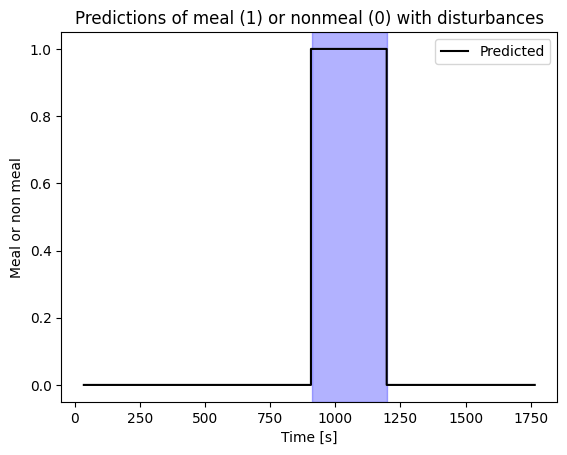

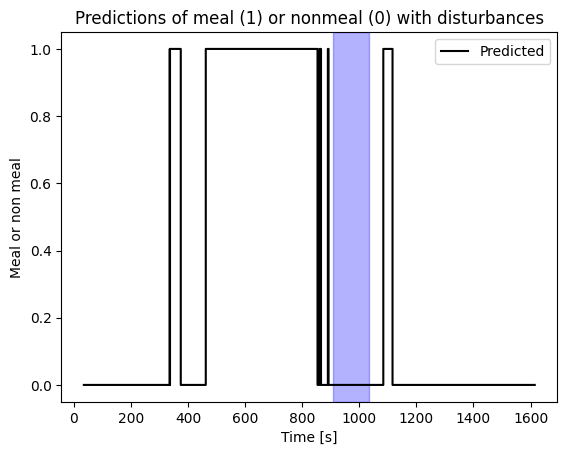

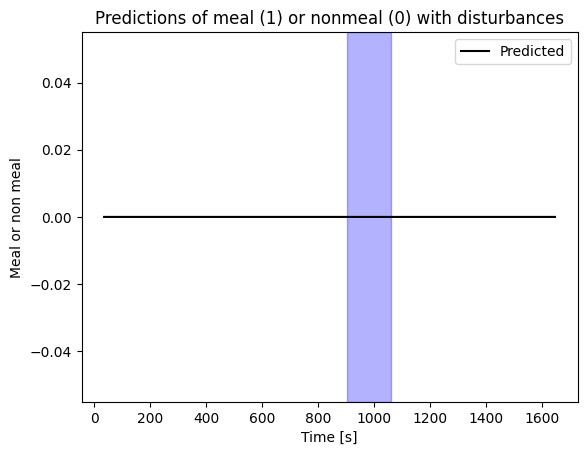

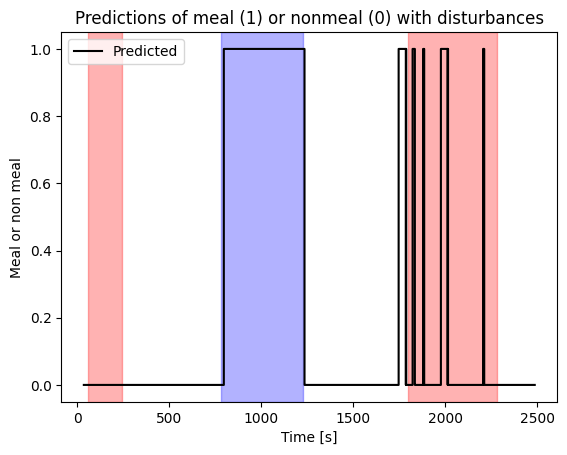

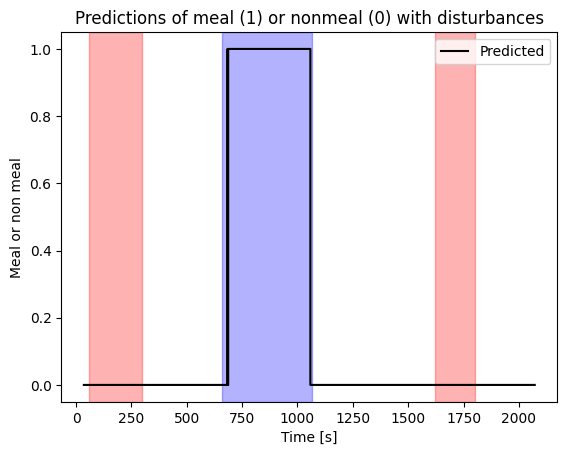

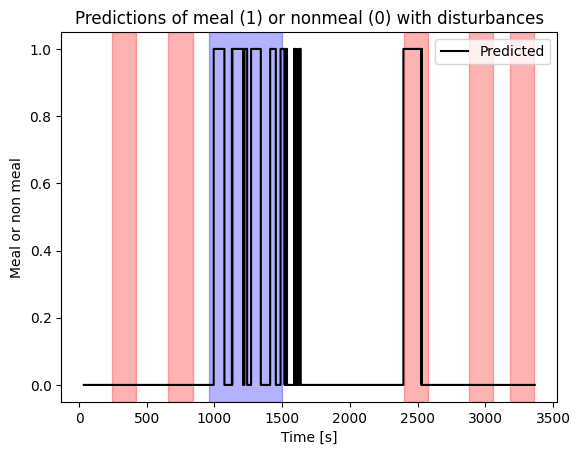

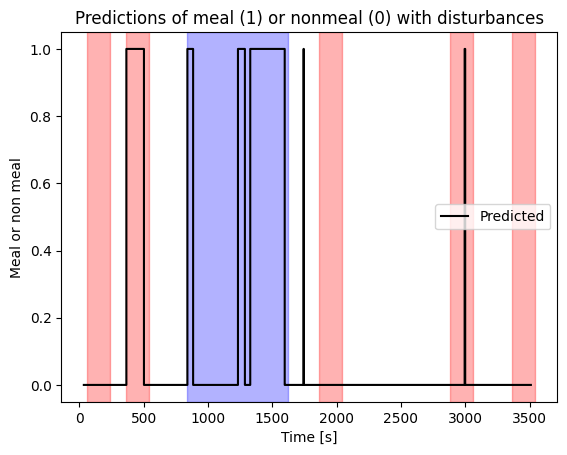

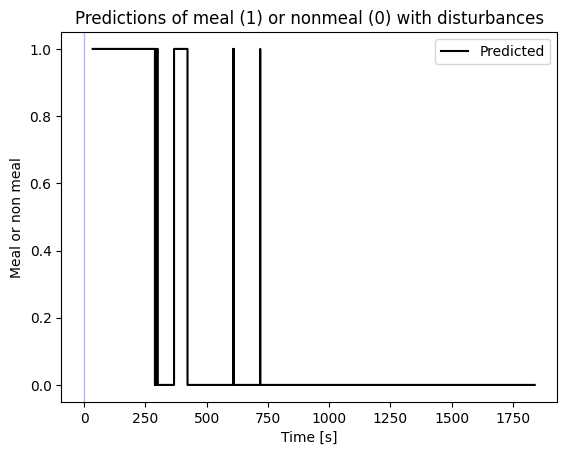

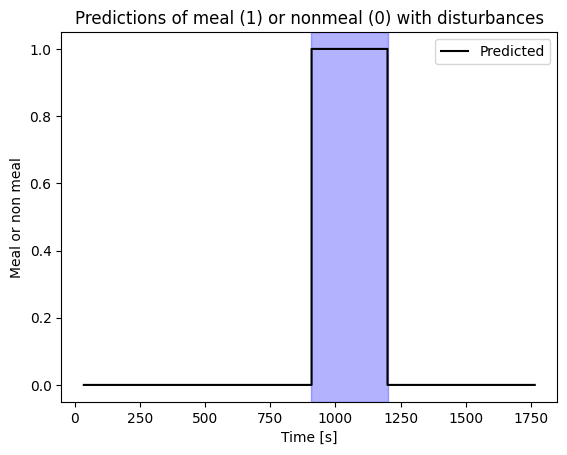

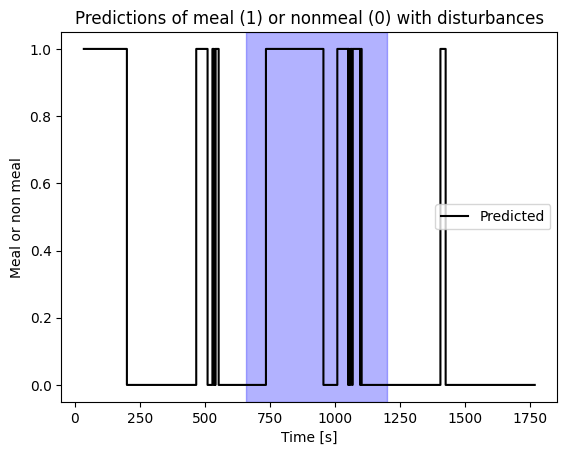

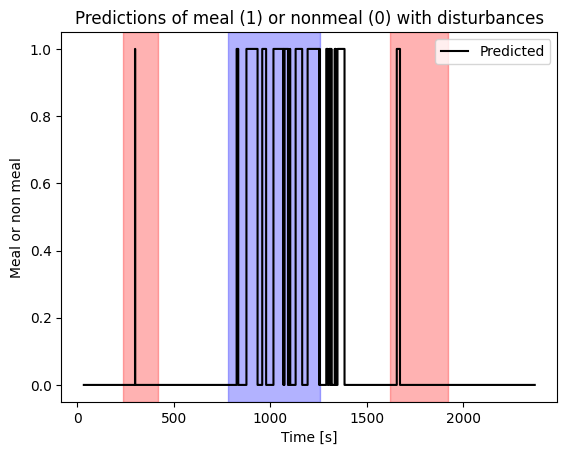

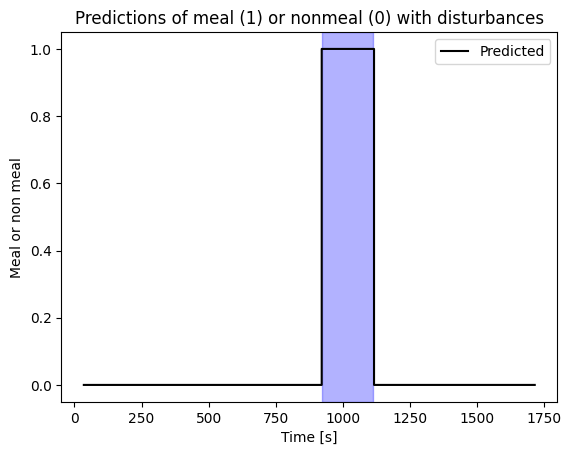

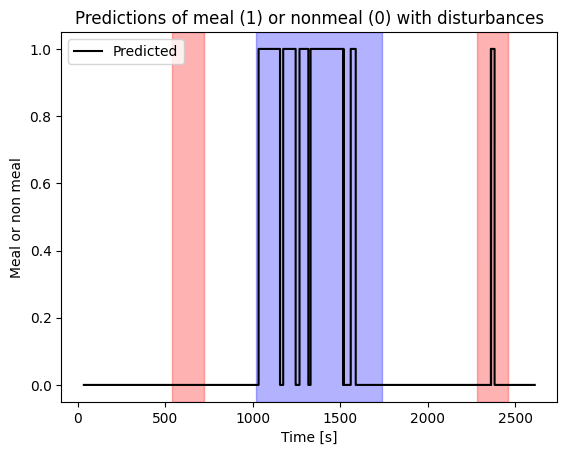

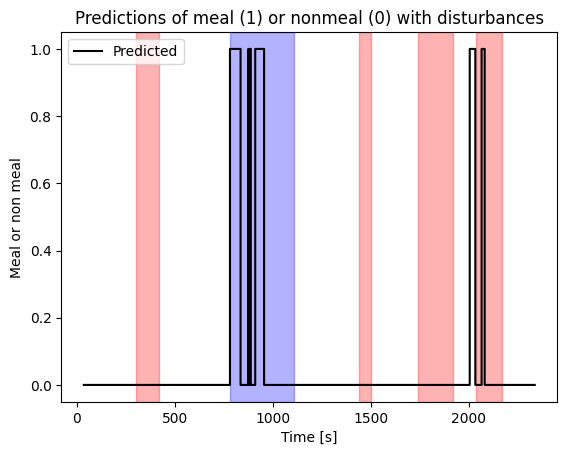

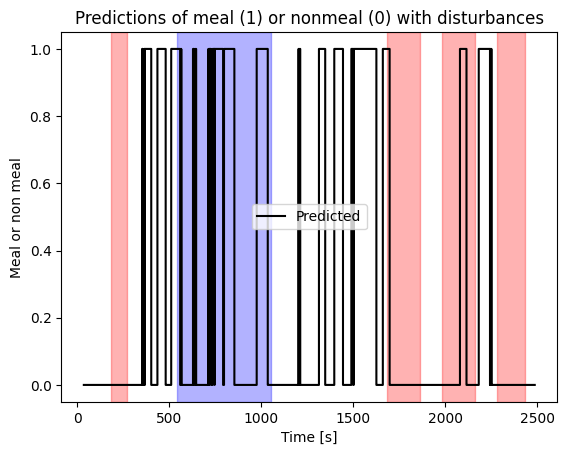

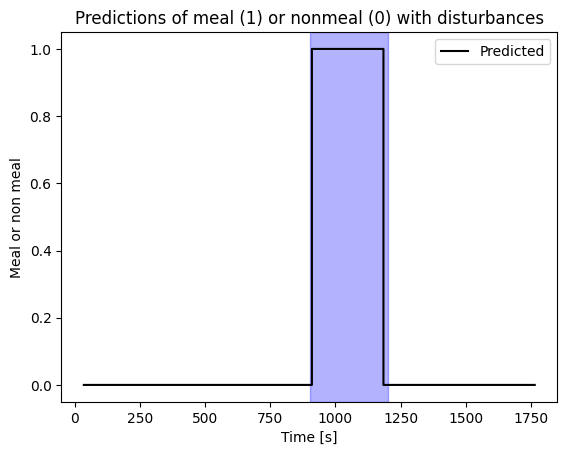

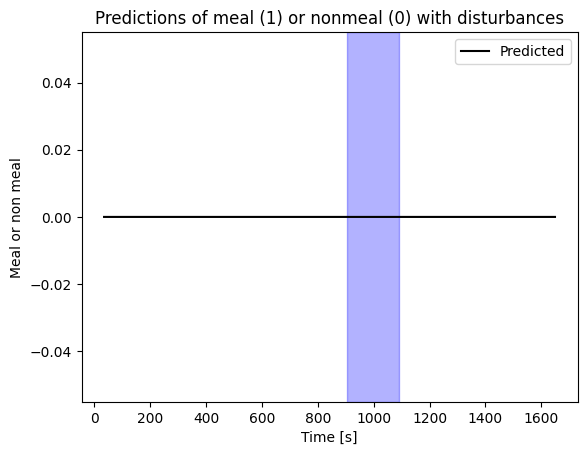

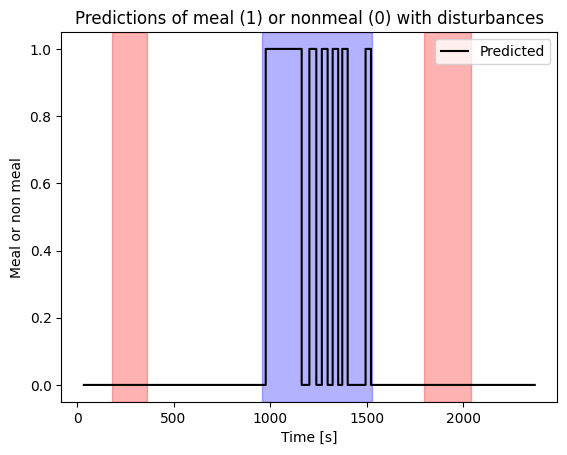

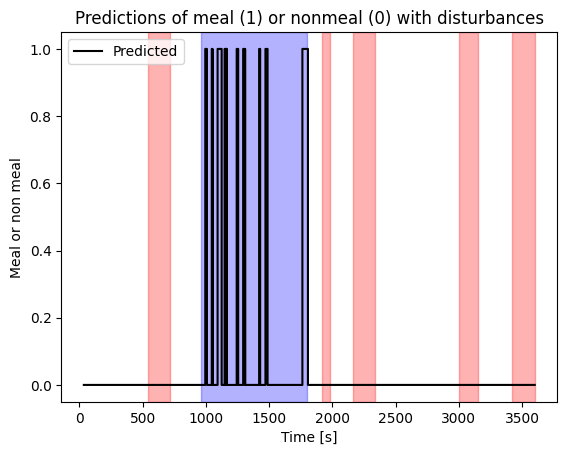

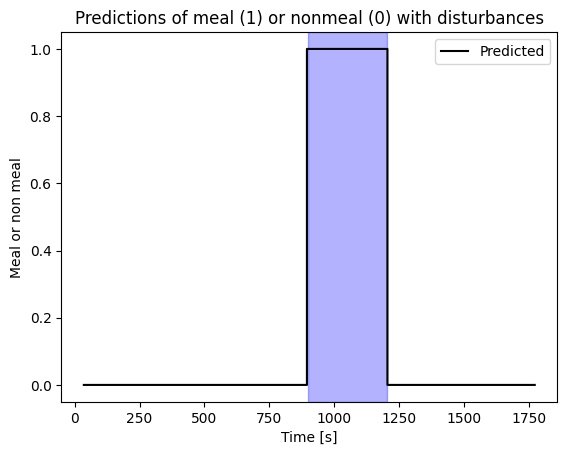

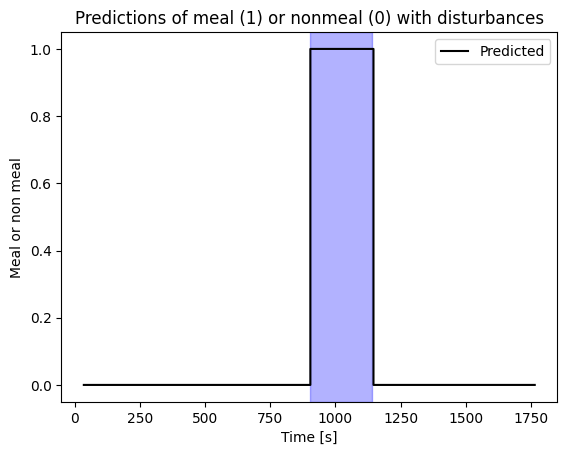

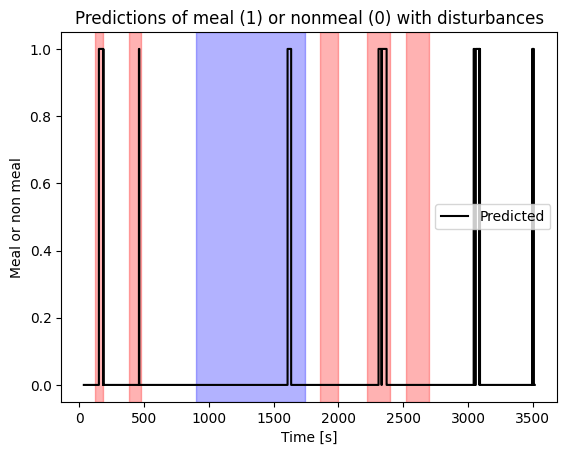

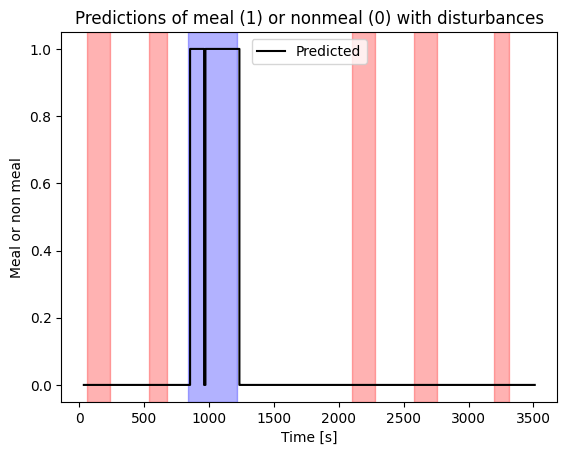

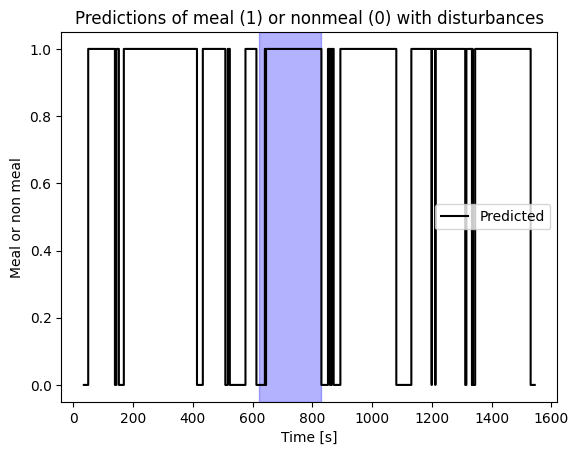

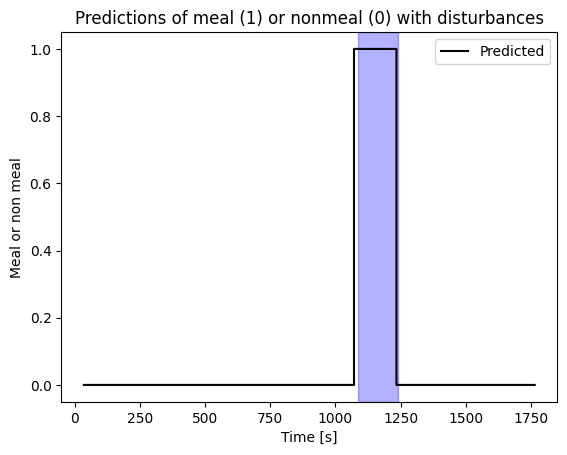

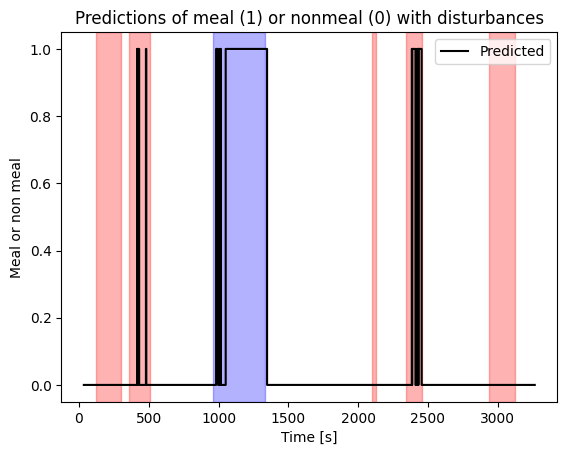

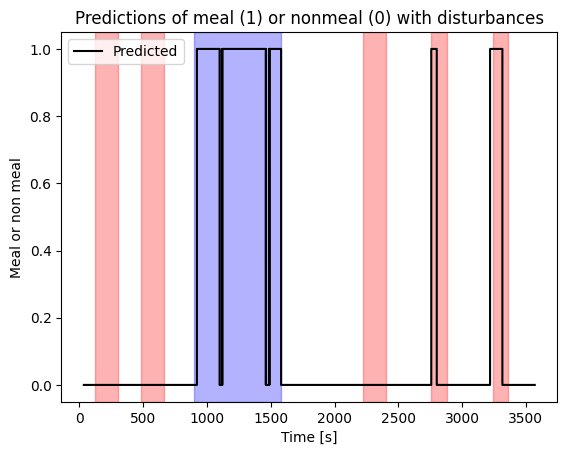

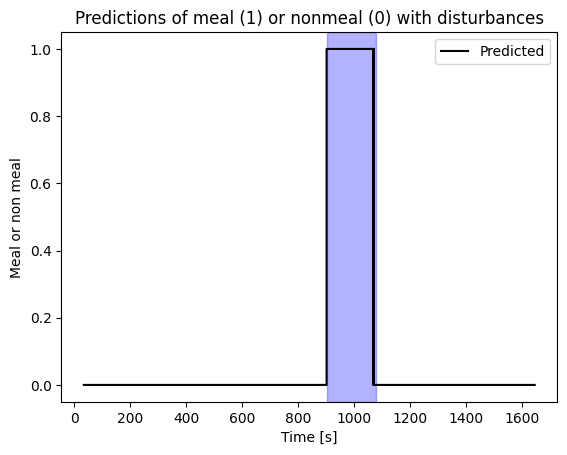

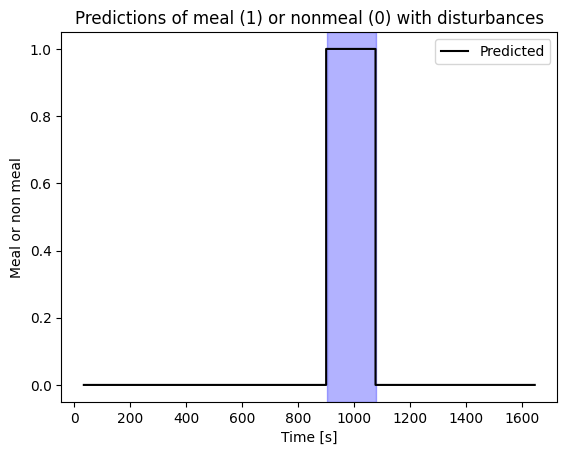

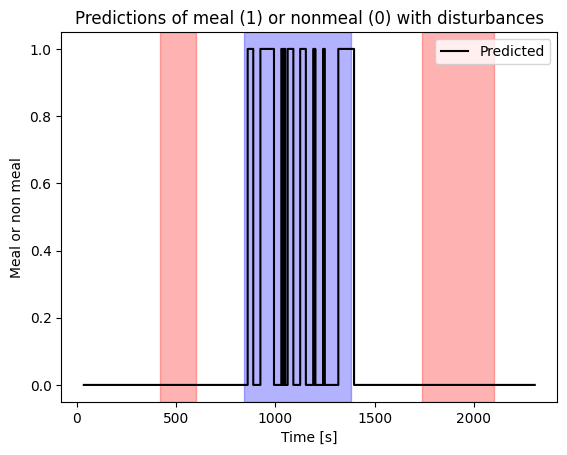

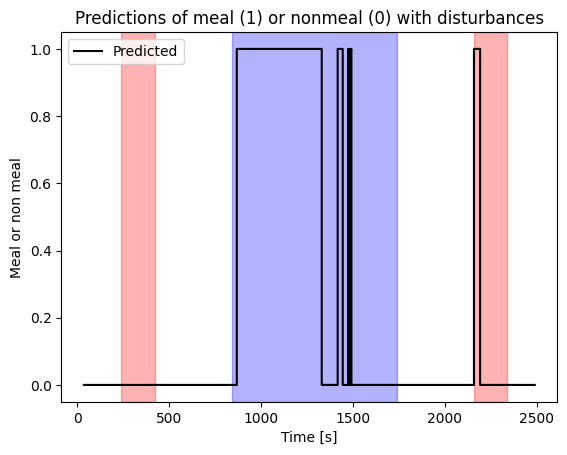

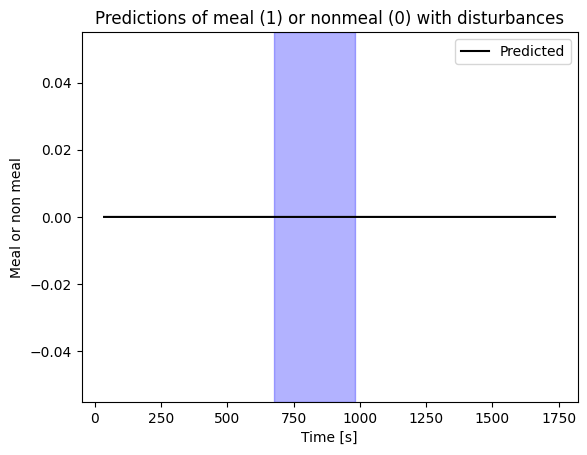

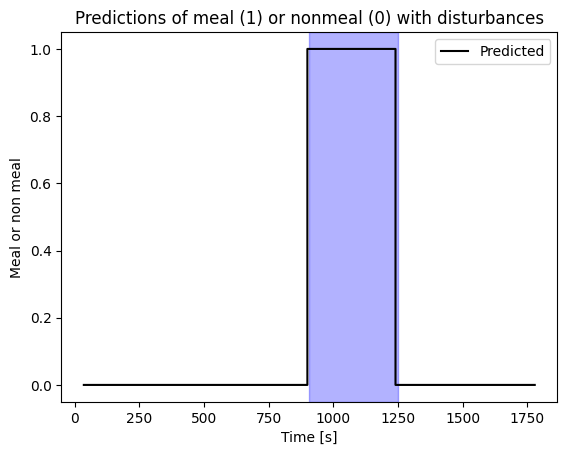

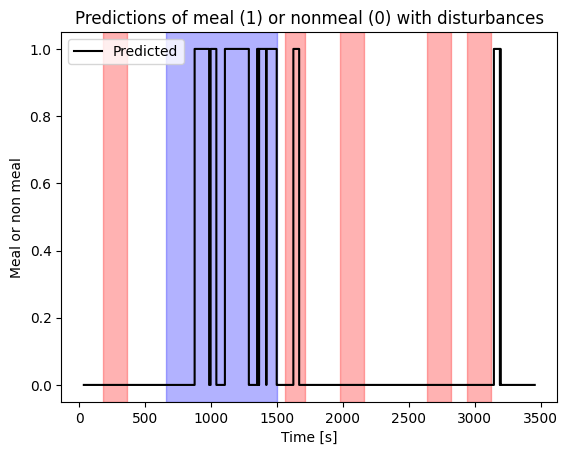

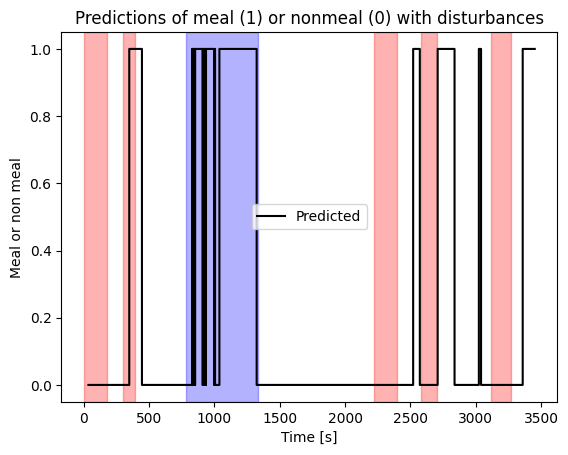

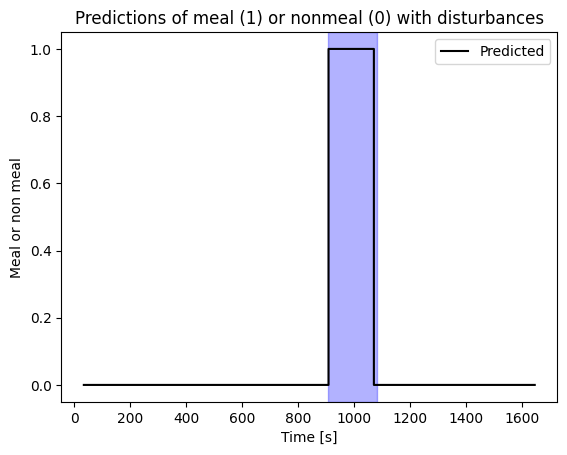

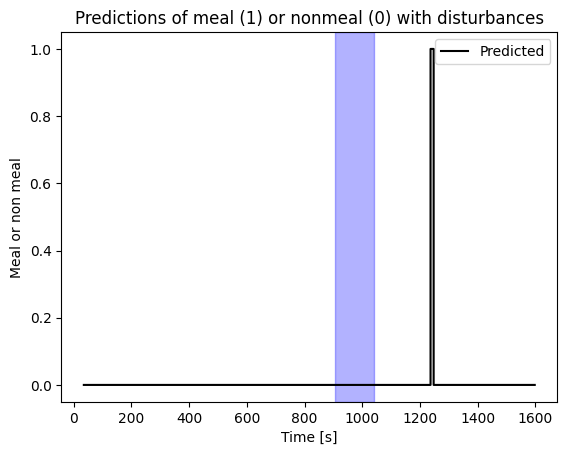

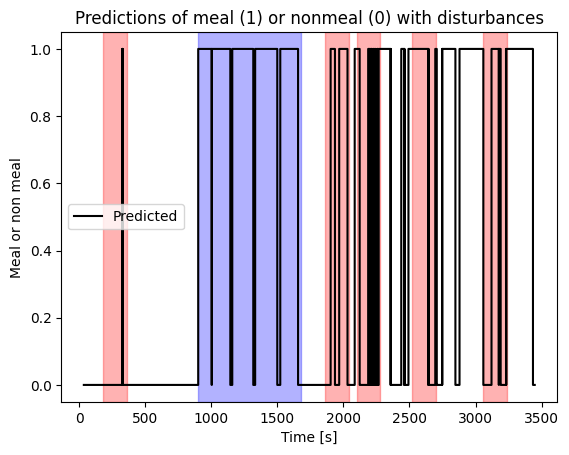

In [53]:
#folder_path = "LDA_test\\data\\20250411_130805"
folder_path = "HMM_validation\\data\\20250411_131102"
find_evolution_parameters(folder_path)